Please upload the file 'combined_data_final_WB.xlsx'.


Saving combined_data_final_WB.xlsx to combined_data_final_WB (9).xlsx
Validation R-squared (R²): 0.9688887104494937
Test Mean Squared Error (MSE): 1682.1524173814905
Test Mean Absolute Error (MAE): 25.770137539720228
Test Root Mean Squared Error (RMSE): 41.014051462657164
Test R-squared (R²): 0.97184237399972
Enter Temperature (C): 24.8
Enter Daily Precipitation (mm): 0
Enter Wind Speed (km/h): 4
Is it a weekend or holiday? (y/n): n
Is it during Stampede? (y/n): n
Enter Day Type (Sunny/Rainy/Snowy): Sunny
Enter Date and Time (YYYY-MM-DD HH:MM:SS): 2024-07-31 22:00:00
Predicted Vehicle Count: 215.37813721039456


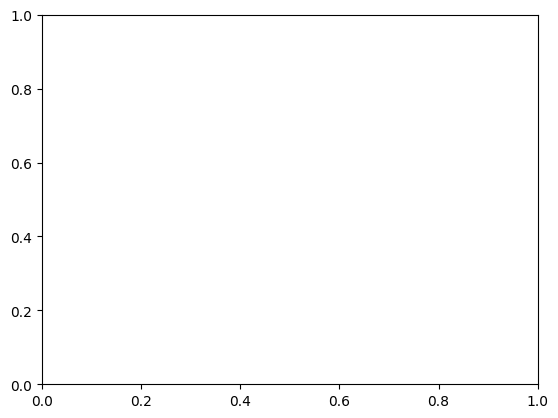

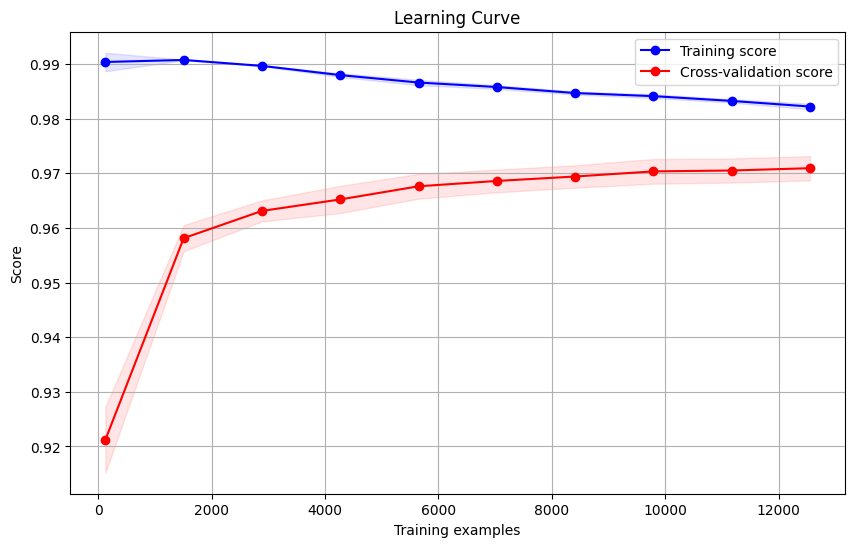

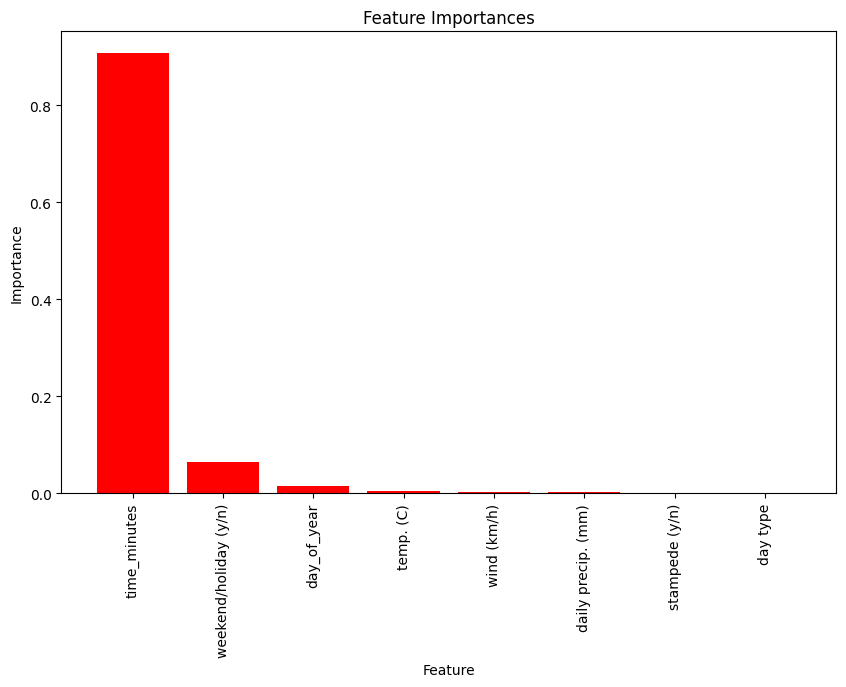

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import files

# Step 1: Upload and Load Data
print("Please upload the file 'combined_data_final_WB.xlsx'.")
uploaded = files.upload()

# Reload the data to ensure no cached data is used
data = pd.read_excel('combined_data_final_WB.xlsx')

# Step 2: Data Preparation
# Convert 'date' and 'time' columns to datetime objects
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute

# Convert categorical columns to numerical values
data['day type'] = data['day type'].map({'Sunny': 0, 'Rainy': 1, 'Snowy': 2})
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})

# Convert 'date' and 'time' to numerical features
data['day_of_year'] = data['date'].dt.dayofyear
data['time_minutes'] = data['hour'] * 60 + data['minute']

# Define features and target
features = ['day_of_year', 'time_minutes', 'weekend/holiday (y/n)',
            'stampede (y/n)', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)', 'day type']
X = data[features]
y = data['vehicle count']

# Step 3: Shuffle data to prevent the model from learning sequential patterns
data = data.sample(frac=1, random_state=32).reset_index(drop=True)

# Step 4: Split Data into Training, Validation, and Test Sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=35)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=35)

# Step 5: Initialize and Train the Model with Fewer Estimators (for faster experimentation)
model = RandomForestRegressor(n_estimators=100, max_depth=12 ,random_state=35)
model.fit(X_train, y_train)

# Step 6: Evaluate on Validation Set to Check for Overfitting
y_val_pred = model.predict(X_val)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation R-squared (R²): {val_r2}")

# Step 7: Evaluate on the Test Set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Test R-squared (R²): {test_r2}")

# Step 8
def predict_vehicle_count():
  """
  Takes user input for features and returns predicted vehicle count.
  """
  # Request user input for each feature
  temp = float(input("Enter Temperature (C): "))
  precip = float(input("Enter Daily Precipitation (mm): "))
  wind = float(input("Enter Wind Speed (km/h): "))
  weekend = input("Is it a weekend or holiday? (y/n): ").strip().lower()
  weekend = 1 if weekend == 'y' else 0
  stampede = input("Is it during Stampede? (y/n): ").strip().lower()
  stampede = 1 if stampede == 'y' else 0
  day_type = input("Enter Day Type (Sunny/Rainy/Snowy): ").strip().capitalize()
  day_type = {'Sunny': 0, 'Rainy': 1, 'Snowy': 2}.get(day_type, 0)  # Default to Sunny if input is unrecognized

  # Extract day and time from user-provided date (assuming YYYY-MM-DD format)
  date_str, time_str = input("Enter Date and Time (YYYY-MM-DD HH:MM:SS): ").split()

  # Convert date and time to appropriate formats
  date = pd.to_datetime(date_str)
  time = pd.to_datetime(time_str, format='%H:%M:%S')

  # Calculate dayofyear and time_minutes from user-provided date and time
  dayofyear = date.dayofyear
  time_minutes = time.hour * 60 + time.minute

  # Prepare input data as a DataFrame
  input_data = pd.DataFrame([[dayofyear, time_minutes, weekend, stampede, temp, precip, wind, day_type]], columns=features)

  # Make prediction
  predicted_count = model.predict(input_data)
  print(f"Predicted Vehicle Count: {predicted_count[0]}")

# Run the function to get a prediction
predict_vehicle_count()


# Step 9A: Plot Learning Curve for Overfitting Analysis
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.01, 1.0, 10)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="red")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="red", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plt.ylim([0, 1])  # Set y-axis limits for clarity (optional)
plot_learning_curve(model, "Learning Curve", X_train, y_train, cv=5)
plt.show()

# Step 9B: Feature Importances for Interpretability
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


Please upload the file 'combined_data_final_EB.xlsx'.


Saving combined_data_final_EB.xlsx to combined_data_final_EB (7).xlsx
Validation R-squared (R²): 0.9499028642243205
Test Mean Squared Error (MSE): 2870.3247221805764
Test Mean Absolute Error (MAE): 30.07274984493525
Test Root Mean Squared Error (RMSE): 53.57541154466829
Test R-squared (R²): 0.9477831319819295


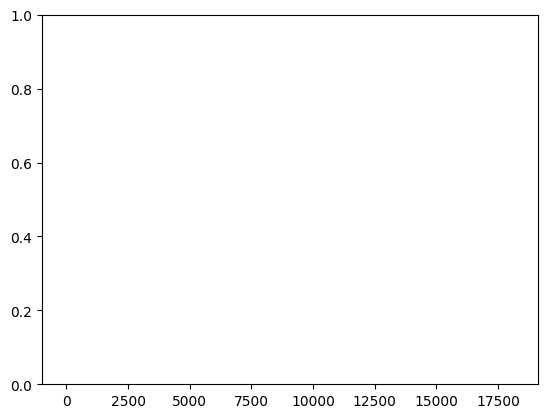

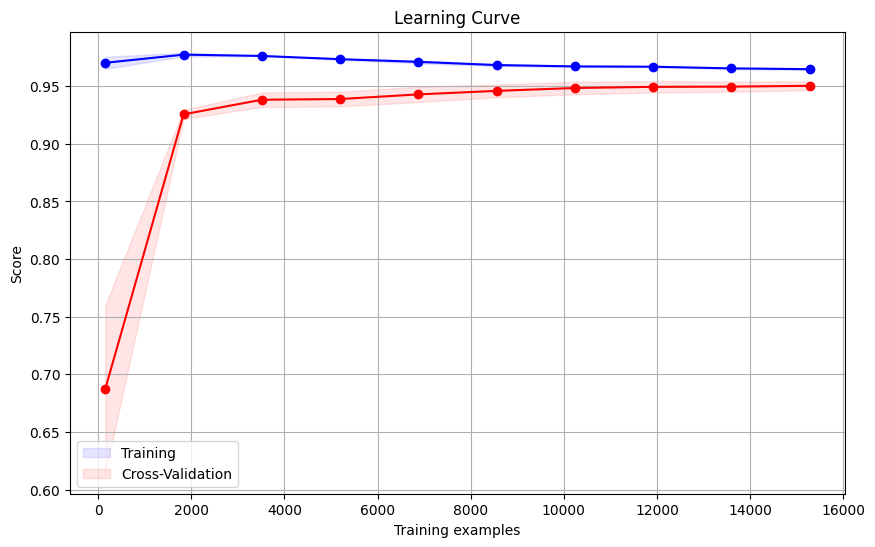

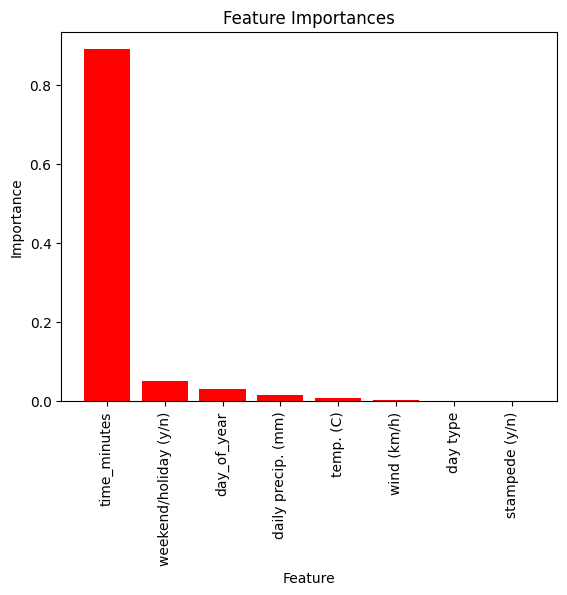

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import files

# Step 1: Upload and Load Data
print("Please upload the file 'combined_data_final_EB.xlsx'.")
uploaded = files.upload()

# Reload the data to ensure no cached data is used
data = pd.read_excel('combined_data_final_EB.xlsx')

# Step 2: Data Preparation
# Convert 'date' and 'time' columns to datetime objects
data['date'] = pd.to_datetime(data['date'])
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')
data['hour'] = data['time'].dt.hour
data['minute'] = data['time'].dt.minute

# Convert categorical columns to numerical values
data['day type'] = data['Day_Type'].map({'Sunny': 0, 'Rainy': 1, 'Snowy': 2})
data['weekend/holiday (y/n)'] = data['weekend/holiday (y/n)'].map({'y': 1, 'n': 0})
data['stampede (y/n)'] = data['stampede (y/n)'].map({'y': 1, 'n': 0})

# Convert 'date' and 'time' to numerical features
data['day_of_year'] = data['date'].dt.dayofyear
data['time_minutes'] = data['hour'] * 60 + data['minute']

# Define features and target
features = ['day_of_year', 'time_minutes', 'weekend/holiday (y/n)',
            'stampede (y/n)', 'temp. (C)', 'daily precip. (mm)', 'wind (km/h)', 'day type']
X = data[features]
y = data['vehicle count']

# Step 3: Shuffle data to prevent the model from learning sequential patterns
data = data.sample(frac=1, random_state=35).reset_index(drop=True)

# Step 4: Split Data into Training, Validation, and Test Sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=35)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=35)

# Step 5: Initialize and Train the Model with Fewer Estimators (for faster experimentation)
model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=32)
model.fit(X_train, y_train)

# Step 6: Evaluate on Validation Set to Check for Overfitting
y_val_pred = model.predict(X_val)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation R-squared (R²): {val_r2}")

# Step 7: Evaluate on the Test Set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error (MSE): {test_mse}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Test R-squared (R²): {test_r2}")

# Step 9A: Plot Learning Curve for Overfitting Analysis
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(0.01, 1.0, 10)):
    plt.figure(figsize=(10, 6))  # Set figure size for clarity
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="blue", label="Training")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="red", label="Cross-Validation")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="red")
    plt.legend(loc="best")
    plt.show()

plt.xlim([-1000, len(X_train)])
plt.ylim([0, 1])
plot_learning_curve(model, "Learning Curve", X_train, y_train, cv=5)
plt.show()

# Step 9B: Feature Importances for Interpretability
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()
